<a href="https://colab.research.google.com/github/Surajpatra700/Potato_Leaf_Prediction/blob/main/Potato_Leaf_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [66]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNEL=3
EPOCHS=20

In [35]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/datasets/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2157 files belonging to 3 classes.


dataset contains 68 batchs with each batches containing pack of 32 images(batch_image & labels)

In [36]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [37]:
len(dataset)

68

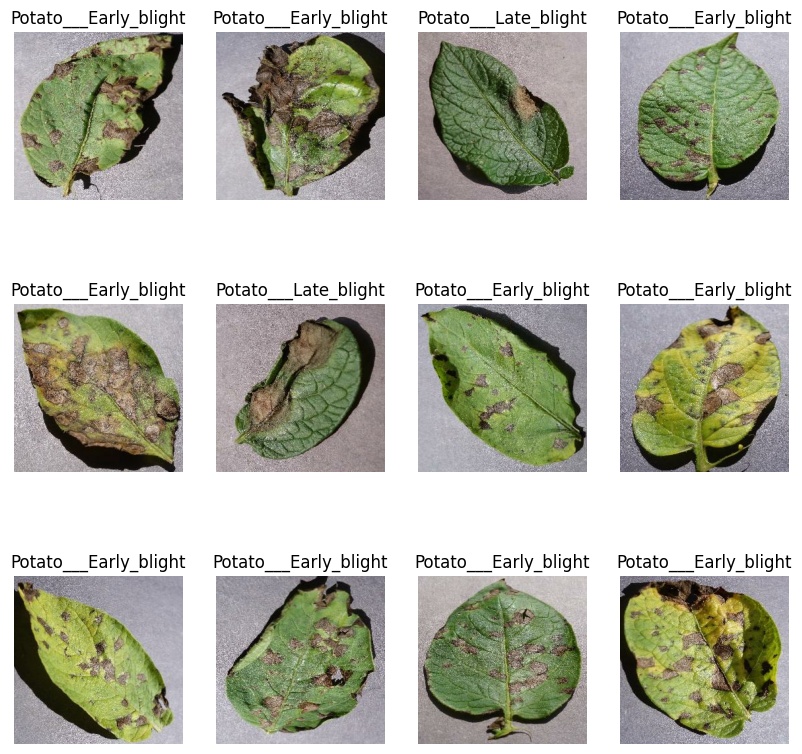

In [38]:
plt.figure(figsize=(10,10))

for image_batch, label_batch in dataset.take(1):
  # print(image_batch.shape)
  # print(label_batch.numpy())
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[label_batch[i]])

In [39]:
len(dataset)

68

In [40]:
#  80% --> training
#  20% --> 10% validation, 10% test

In [41]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [42]:
train_ds = dataset.take(54)
len(train_ds)

54

In [43]:
test_ds = dataset.skip(54) # it will skip 1st 54 dataset
len(test_ds)

14

In [44]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [45]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [46]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [47]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(len(ds) * train_split)
  val_size = int(len(ds) * val_split)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [48]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [49]:
len(train_ds)

54

In [50]:
#  Pipelining 3 function into 1
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [51]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [52]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [62]:
#  Model Building

input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE,CHANNEL)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(3, activation="softmax")
])

model.build(input_shape=input_shape)

In [63]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 256, 256, None)    0         
                                                                 
 sequential_6 (Sequential)   (None, 256, 256, None)    0         
                                                                 
 conv2d_42 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_42 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                               

In [64]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [67]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/20
 3/54 [>.............................] - ETA: 3:04 - loss: 0.9936 - accuracy: 0.4062

KeyboardInterrupt: ignored